# Depleting serum/plasma samples of Delta RBD-binding antibodies

### Set up Analysis

Import packages.

In [1]:
import itertools
import math
import os
import re
import warnings

from IPython.display import display, HTML

import matplotlib
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib as mpl
import matplotlib.pyplot as plt
from mizani.formatters import scientific_format
import natsort

import numpy as np
import pandas as pd
from plotnine import *
import seaborn

import neutcurve
from neutcurve.colorschemes import CBMARKERS, CBPALETTE
import seaborn

import scipy.stats

import yaml

In [2]:
warnings.simplefilter('ignore')

Use seaborn theme and change font:

In [3]:
theme_set(theme_seaborn(style='white', context='talk', font='FreeSans', font_scale=1))
plt.style.use('seaborn-white')

Read config file:

In [4]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

In [5]:
datadir=config['elisa_data_dir']

resultsdir='results/rbd_depletion_elisas'
os.makedirs(resultsdir, exist_ok=True)

In [6]:
pd.options.display.max_rows = 100

## RBD depletion ELISAs

Rachel performed 3 rounds of depletions (or mock) with a ratio of 3:1 beads:serum with commerical Delta RBD beads from ACROBioSystems (MBS-K037). She then performed ELISAs for binding of serum to commercial proteins purchased from ACRO, Delta RBD (SPD-C52Hh) or Delta spike (SPN-C52He).

serum,serum_group,depleted,ligand,date,dilution_factor,OD450,dilution,serum_name
Delta_10,Delta infection,mock depleted,Delta RBD,211206,8100,2.23080,0.000123,Delta_10\n(Delta infection)
Delta_11,Delta infection,1x depleted,Delta RBD,211206,8100,0.04130,0.000123,Delta_11\n(Delta infection)
Delta_11,Delta infection,2x depleted,Delta RBD,211206,8100,0.01885,0.000123,Delta_11\n(Delta infection)
Delta_11,Delta infection,3x depleted,Delta RBD,211206,8100,-0.00085,0.000123,Delta_11\n(Delta infection)
Delta_11,Delta infection,mock depleted,Delta RBD,211206,8100,0.98205,0.000123,Delta_11\n(Delta infection)


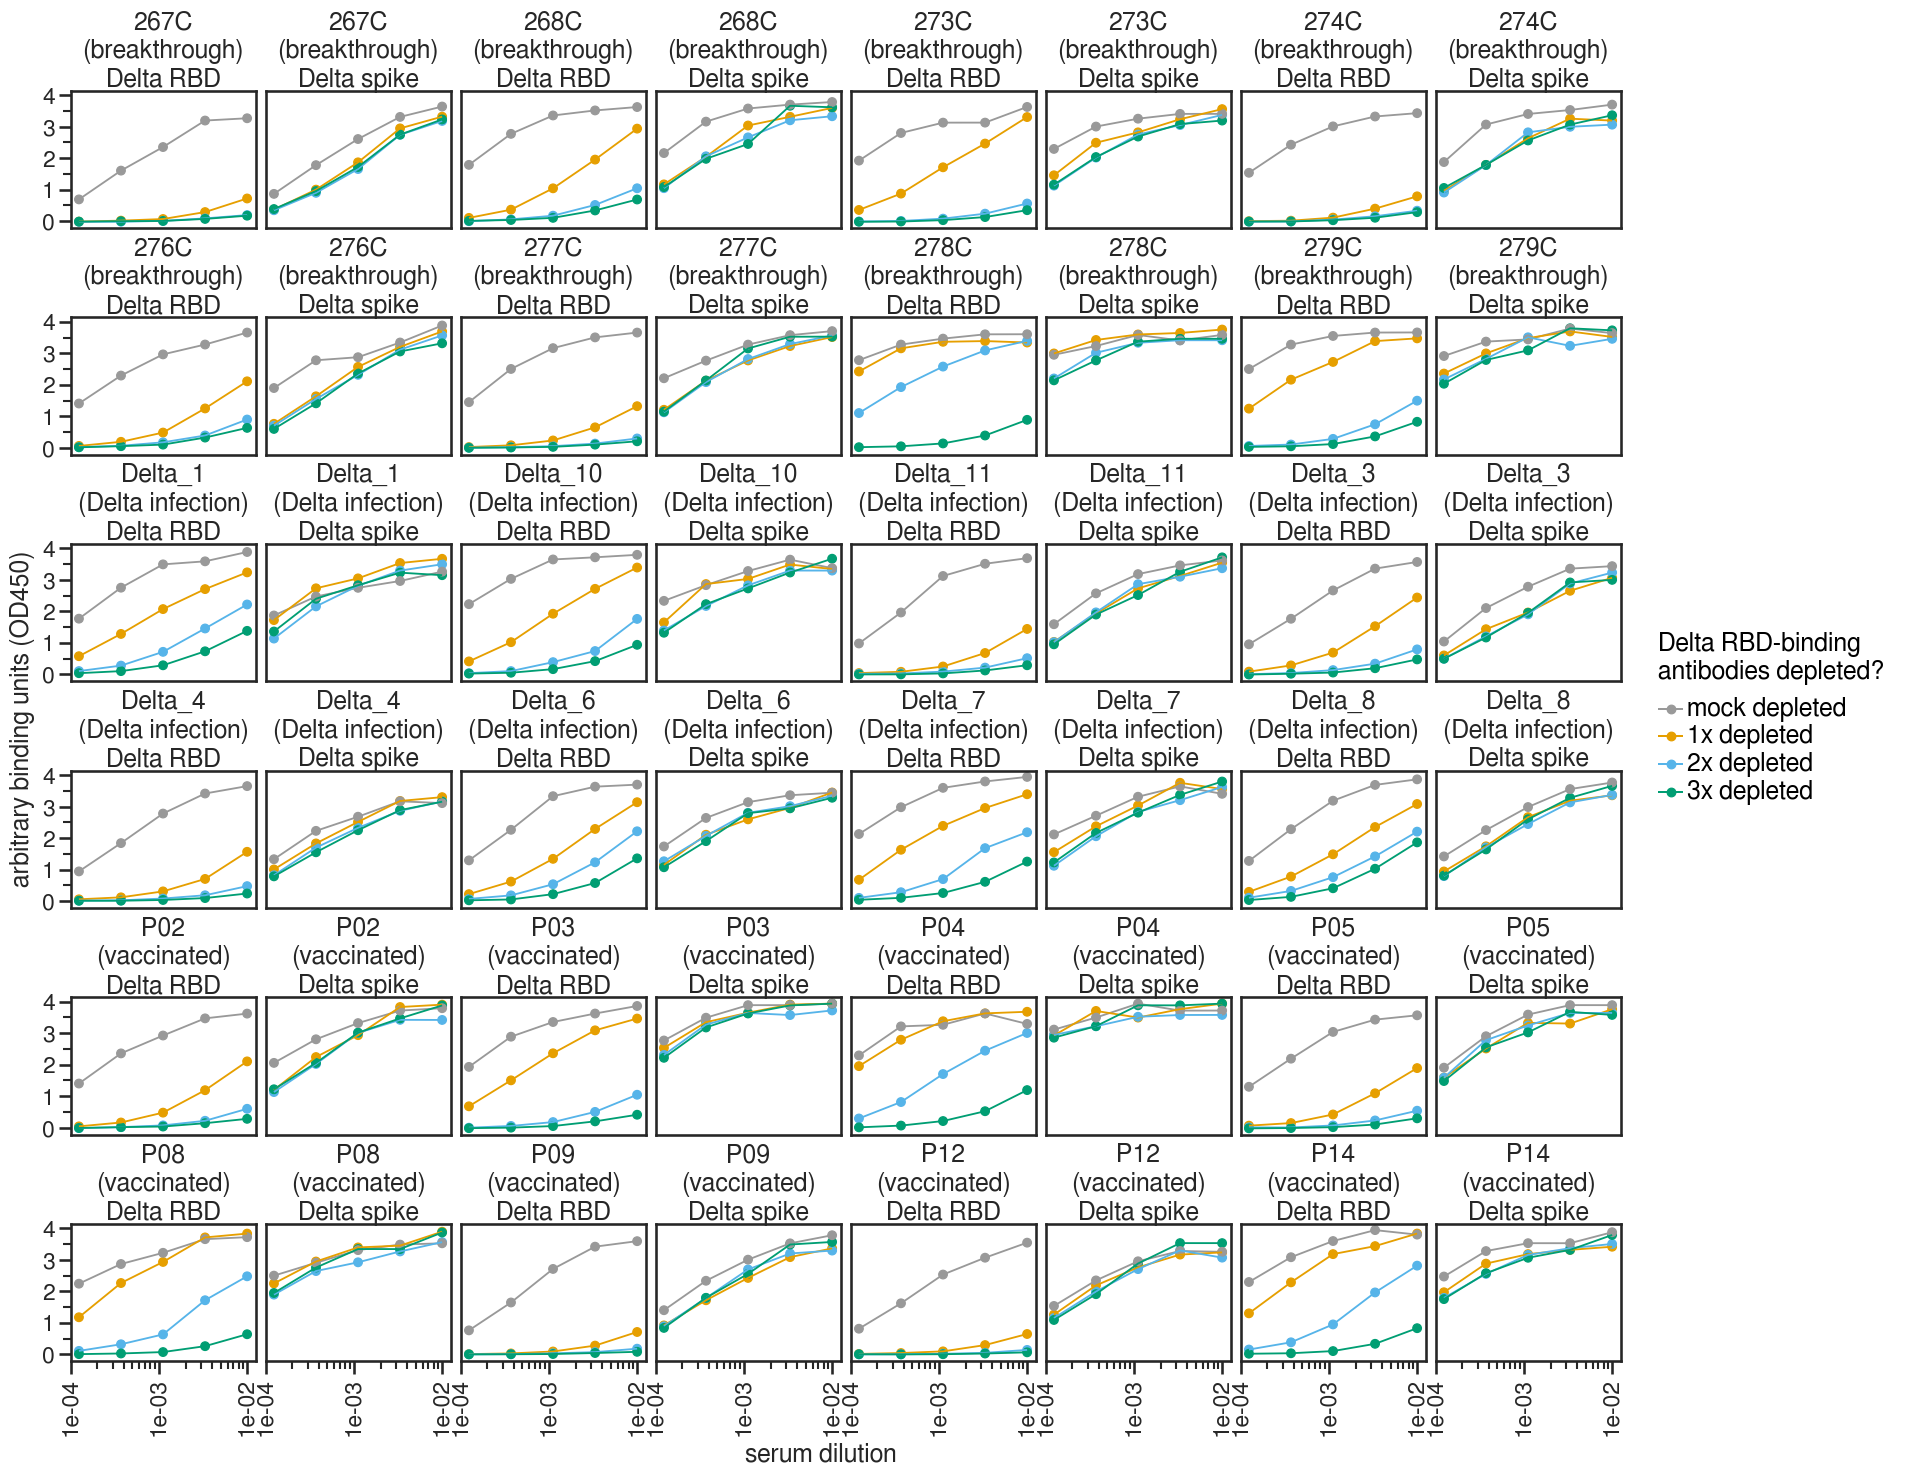

In [7]:
titration_df = pd.DataFrame()

for f in config['elisa_data_files']:
    data = os.path.join(datadir, f)

    df = (pd.read_csv(data)
                    .melt(
                            id_vars=['serum', 'serum_group', 'depleted', 'ligand', 'date'], 
                            var_name='dilution_factor', 
                            value_name='OD450'
                           )
                    .assign(dilution_factor=lambda x: x['dilution_factor'].astype(int),
                            dilution=lambda x: 1/x['dilution_factor'],
                           )
                   )
    titration_df=pd.concat([titration_df, df])

titration_df = (titration_df
                .assign(depleted=lambda x: pd.Categorical(x['depleted'], 
                                                          categories=config['depletions'], 
                                                          ordered=True
                                                         ),
                        serum_name=lambda x: x['serum']+'\n('+x['serum_group']+')'
                       )
               )

display(HTML(titration_df.tail().to_html(index=False)))

ncol=8
nrow=math.ceil(len(titration_df[['ligand', 'serum', 'serum_group']].drop_duplicates())/8)

p = (
    ggplot((titration_df),
           aes('dilution', 
               'OD450', 
               color='depleted',
               )) +
    geom_point(size=3) +
    geom_path(aes(color='depleted'), size=0.75) +
    scale_x_log10(name='serum dilution', labels=scientific_format(digits=0)) +
    facet_wrap('~serum_name+ligand', ncol=ncol) +
    theme(figure_size=(2.5 * ncol, 2.75 * nrow),
          axis_text_x=element_text(angle=90),
          strip_background=element_blank(),
          strip_margin_y=0.35,
          subplots_adjust={'hspace':0.65},
         ) +
    scale_color_manual(values=CBPALETTE[0:], name='Delta RBD-binding\nantibodies depleted?') +
    ylab('arbitrary binding units (OD450)')
    )

_ = p.draw()

p.save(f'{resultsdir}/all_ELISAs.pdf', limitsize=False)
p.save(f'{resultsdir}/all_ELISAs.png', limitsize=False)